# Camera Calibration

Briefly state how you computed the camera matrix and distortion coefficients. Provide an example of a distortion corrected calibration image.


In [1]:
import cv2
import glob
import numpy as np
from math import *
import matplotlib.pyplot as plt
import matplotlib.image as mpimage
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
%matplotlib inline

In [2]:
def calibrate_camera(images, nx, ny):
    objectpoints = []  # 3D 
    imgpoints = []  # 2D 

    objp = np.zeros((nx*ny,3), np.float32)
    objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1, 2)

    fname = images[0]
    for fname in images:
        img = mpimage.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
        if ret:
            objectpoints.append(objp)
            imgpoints.append(corners)

    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objectpoints, imgpoints, gray.shape[::-1],None,None)
    
    return mtx, dist

def camera_setup():
    images = glob.glob('camera_cal/calibration*.jpg')
    nx = 9
    ny = 6
    mtx, dist = calibrate_camera(images, nx, ny)
    return mtx, dist

In [3]:
mtx, dist = camera_setup()

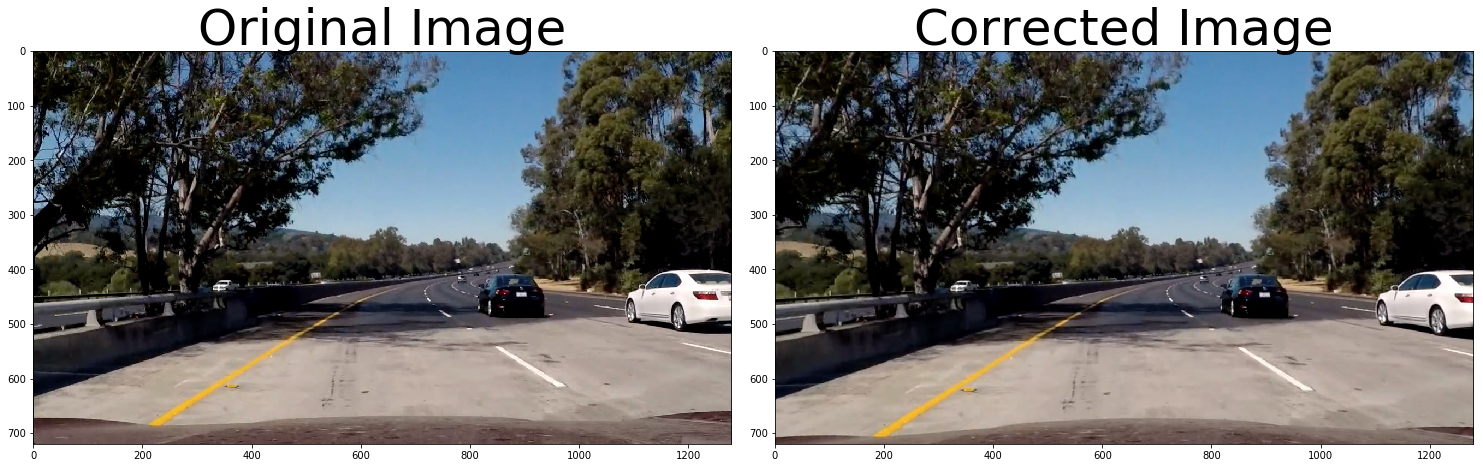

In [4]:
image = mpimage.imread('test_images/test5.jpg')

undist = cv2.undistort(image, mtx, dist, None, mtx)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undist)
ax2.set_title('Corrected Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

plt.savefig('write_up/test5_undistort.jpg')

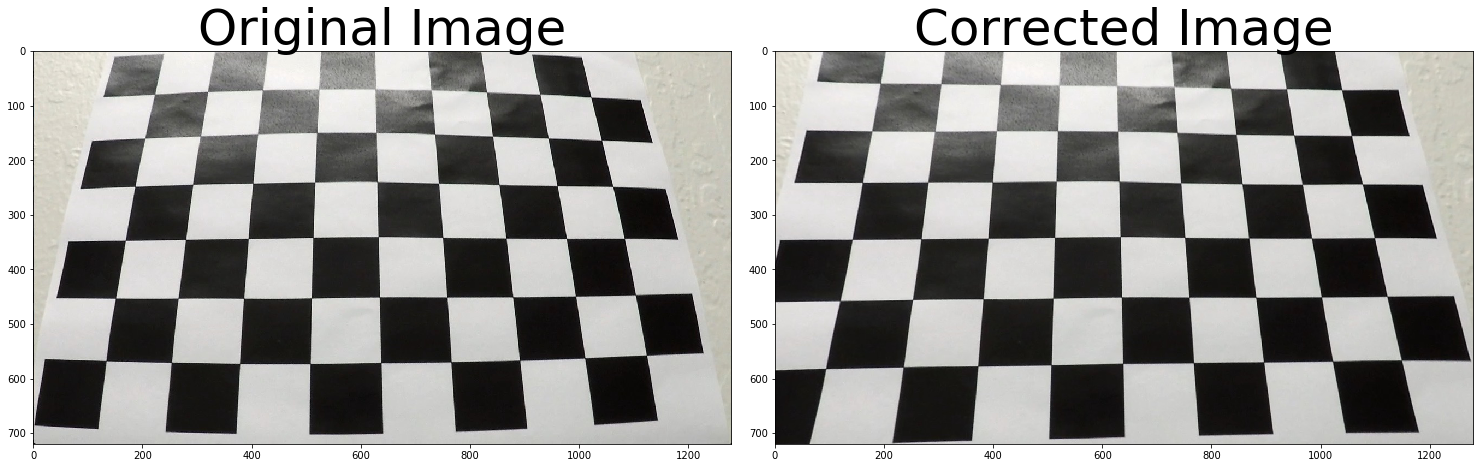

In [5]:
# undistort a checkboard image
image = mpimage.imread('camera_cal/calibration3.jpg')
undist = cv2.undistort(image, mtx, dist, None, mtx)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undist)
ax2.set_title('Corrected Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

plt.savefig('write_up/calibration3_undistort.jpg')


# 2. Describe how you used color transforms, gradients or other methods to create a thresholded binary image.  Provide an example of a binary image result.
I use 2 kinds of gradient threshold
1. Along the X axis (since lane line is vertical)
2. Directional gradient with threshold 30 and 90 degree ( since I'm interested in only edges of a particular orientation)

I then apply color threshhold as followings:
1. R & G channel threshhold to detect yellow line
2. L (Lightness) channel threshhold so that edge generated due to shadow will not be taken into account
3. S (Saturation) channel 

In [6]:
# Define a function that takes an image, gradient orientation,
# and threshold min / max values.
def abs_sobel_thresh(gray, orient='x', thresh_min=0, thresh_max=255):
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Return the result
    return binary_output

# Define a function to threshold an image for a given range and Sobel kernel
def dir_threshold(gray, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

def get_threshold (img):
    img = cv2.undistort(img, mtx,dist,None, mtx)
    
    # convert to gray scale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    height, width = gray.shape
    
    # gradient threshold on x
    sx_binary = abs_sobel_thresh(gray,'x',10,200)
    
    # gradient direction threshold 
    direction_binary = dir_threshold(gray,thresh = (np.pi/6, np.pi/2))
    
    # combine 2 above binary
    sx_direction_binary = ((sx_binary==1) & (direction_binary==1))
    
    # R & G threshhold
    color_thresh = 160
    R = img[:,:,0]
    G = img[:,:,1]
    RG_binary = (R > color_thresh) & (G > color_thresh)
    
    # LHS threshold
    HLS = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    S = HLS[:,:,2]
    L = HLS[:,:,1]
    H = HLS[:,:,0]
    
    # S channel detect bright yellow and white lanes
    S_thresh = (90,255)
    S_binary = (S> S_thresh[0]) & (S <= S_thresh[1])
    
    # L channel threshhold to avoid shadow pixels
    L_thesh= (120,255)
    L_binary = (L > L_thesh[0]) & (L <= L_thesh[1])
    
    # Combine all thresholds
    combined_binary = np.zeros_like(R)
    combined_binary[(RG_binary & L_binary ) & (S_binary | sx_direction_binary )] = 1
    
    # apply to masked region
    mask = np.zeros_like(combined_binary)
    cropped_region = np.array([[0,height], [width/2, int(0.5*height)], \
                                            [width, height]], dtype=np.int32)
    cv2.fillPoly(mask, [cropped_region], 1)
    thresholded = cv2.bitwise_and(combined_binary, mask)
    
    return thresholded

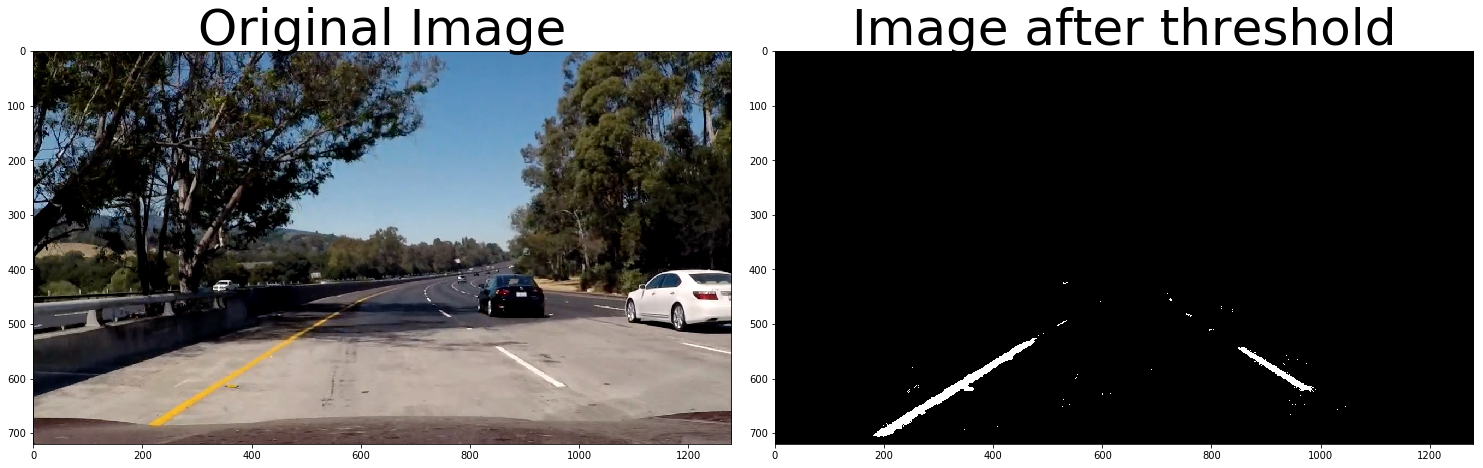

In [7]:
img = mpimage.imread('test_images/test5.jpg')
img_thresh = get_threshold (img)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(img_thresh,cmap='gray')
ax2.set_title('Image after threshold', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

plt.savefig('write_up/test5_threshold.jpg')

# 3. Describe how (and identify where in your code) you performed a perspective transform and provide an example of a transformed image.

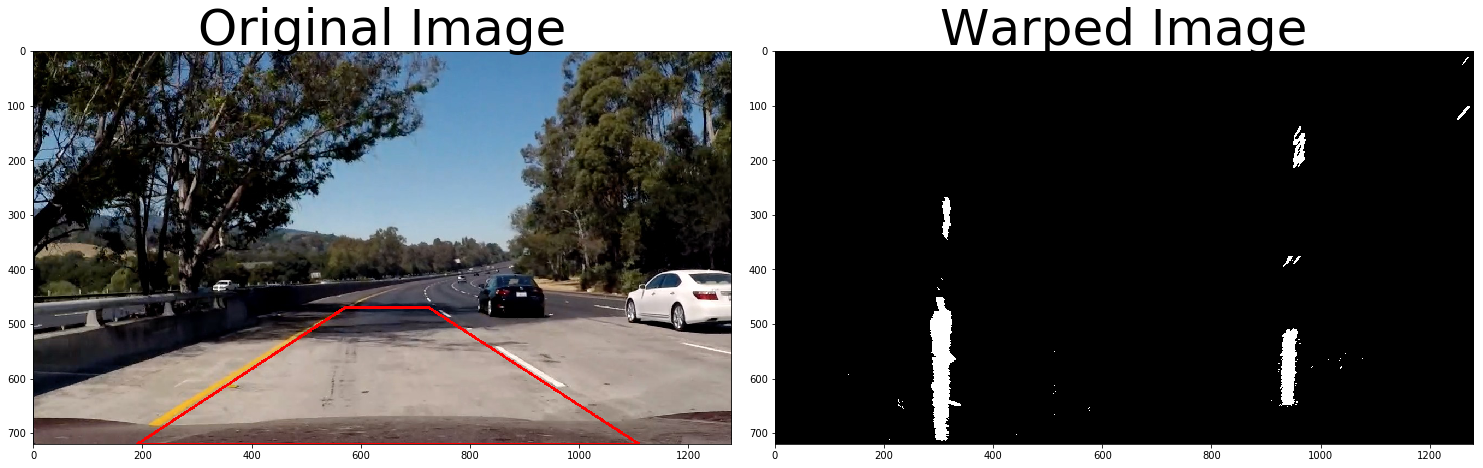

In [8]:
# Mannually extract vertices
bottom_left = [190,720]
bottom_right = [1110, 720]
top_left = [570, 470]
top_right = [725, 470]

source = np.float32([bottom_left,bottom_right,top_right,top_left])

pts = np.array([bottom_left,bottom_right,top_right,top_left], np.int32)
pts = pts.reshape((-1,1,2))
copy = img.copy()
cv2.polylines(copy,[pts],True,(255,0,0), thickness=3)

# Destination points are chosen 
bottom_left = [320,720]
bottom_right = [920, 720]
top_left = [320, 1]
top_right = [920, 1]

dst = np.float32([bottom_left,bottom_right,top_right,top_left])
M = cv2.getPerspectiveTransform(source, dst)
M_inv = cv2.getPerspectiveTransform(dst, source)
img_size = (img.shape[1], img.shape[0])

binary_warped = cv2.warpPerspective(img_thresh, M, img_size , flags=cv2.INTER_LINEAR)
    
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,8))
f.tight_layout()
ax1.imshow(copy)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(binary_warped, cmap='gray')
ax2.set_title('Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.savefig('write_up/test5_perspective_transform.jpg')

# 4. Describe how (and identify where in your code) you identified lane-line pixels and fit their positions with a polynomial?
## 4.1 Identify the lane pixels: Part 1 Histogram
The peak is where the position of the lane in the image


304
939


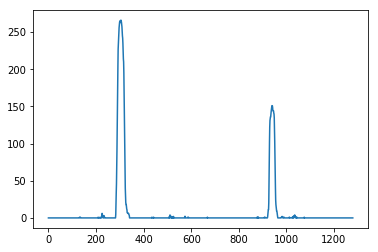

In [9]:
histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
plt.plot(histogram)
plt.savefig('write_up/histogram.jpg')
leftx_base = np.argmax(histogram[:(histogram.shape[0]/2)])
print(leftx_base) # where the left line is

rightx_base = np.argmax(histogram[(histogram.shape[0]/2):]) + int(histogram.shape[0]/2)
print(rightx_base) # where the right lane is

## 4.2 Identify the lane pixels: Part 2 - Sliding Window and Fit a Polynomial
I perform sliding window starting with the left and right calculated above.

In [10]:
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
# Choose the number of sliding windows
nwindows = 10
# Set height of windows
window_height = np.int(binary_warped.shape[0]/nwindows)
# Identify the x and y positions of all nonzero pixels in the image
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base
# Set the width of the windows +/- margin
margin = 100
# Set minimum number of pixels found to recenter window
minpix = 50
# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

# Step through the windows one by one
for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = binary_warped.shape[0] - (window+1)*window_height
    win_y_high = binary_warped.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    # Draw the windows on the visualization image
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
    cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
    # Identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

### Visualization

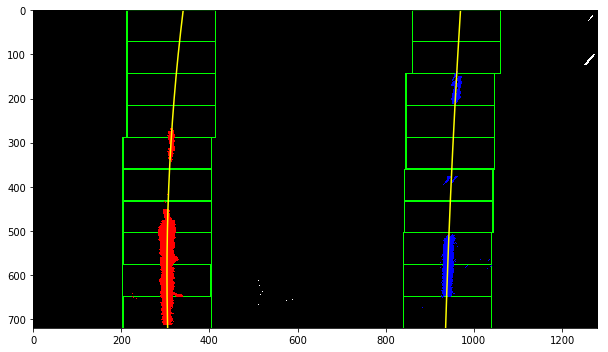

In [11]:
# Visualization
# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

f,ax1 = plt.subplots(1, 1, figsize=(10,5))
f.tight_layout()
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, binary_warped.shape[1])
plt.ylim(binary_warped.shape[0], 0)
plt.savefig('write_up/est5_slidingWindow.jpg')

## 4.3 Identifying the lane pixels: Part 3 - Search around detected line in preceding frame
I search around a margin of 50 pixels of the previous detected lane lines

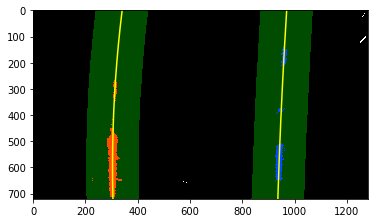

In [12]:
# Assume you now have a new warped binary image from the next frame of video (call binary_warped)
# Skip the sliding window step
# Green Shade shows where we searched for the lines
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
margin = 100
left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

# Again, extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds]
# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)
# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

# Create an image to draw on and an image to show the selection window
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
window_img = np.zeros_like(out_img)
# Color in left and right line pixels
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)
plt.savefig('write_up/test5_searchAround.jpg')

## 4.4 Identifying the plane pixels: Part4 - Computing the radius of curvature and the position of the vehicle with respect to center.
Use method mentioned in classroom. I need to convert from pixel to metter because curvature calculation is performed in pixel instead of real world meters

The center of the image is the position of the car. The mean of the pixels closest to the car is the center of the lane. The difference between these 2 values is the offset

In [13]:
def get_curvature_radius(x_values, warped):
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    num_rows = warped.shape[0]
    y_pixels =  np.linspace(0, num_rows-1,num_rows)
    y_eval = np.max(y_pixels)
    
    # Fit new polynomials to x,y in world space
    fit_curve = np.polyfit(y_pixels *ym_per_pix, x_values*xm_per_pix, 2)
    curve_rad = ((1 + (2*fit_curve[0]*y_eval*ym_per_pix + fit_curve[1])**2)**1.5) / np.absolute(2*fit_curve[0])
    return curve_rad

def get_offset_from_center(left_fitx, right_fitx, pic_width):
    center_lane = (left_fitx[719] + right_fitx[719])/2.0
    xm_per_pix = 3.7/700
    center_pic = pic_width/2.0 
    center_offset_pixel  = abs(center_pic - center_lane)
    center_offset_meter = xm_per_pix * center_offset_pixel
    return center_offset_meter
    
left_cruve_radius = get_curvature_radius(left_fitx, binary_warped)
right_curve_radius = get_curvature_radius(right_fitx, binary_warped)
average_curve_radius = (left_cruve_radius + right_curve_radius)/ 2.0
print("Radius of curvation: %0.2f meter" % average_curve_radius)

# Calculate center offset
center_offset_meter = get_offset_from_center(left_fitx, right_fitx, pic_width= binary_warped.shape[0])
print("Center offset : %.2f meter" % center_offset_meter)

Radius of curvation: 4481.51 meter
Center offset : 1.38 meter


# Pipeline
Below are steps in Pipeline
1. Apply threshold
2. Perspective transform
3. If there is no polynomial coefficients of lane fit from previous frame, perform first search of the image as followings:
 1. Perform histogram to get left and right base
 2. From left & right base found in step A, perform window sliding to get all nonzero pixels within the window
 3. Get predict line by polynomial fit those nonzero pixels found in step B
4. If there is polynomial coefficient of lane fit from previous frame, find the nonzero pixels within a margin of the predicted lanes from previous framework and run a polynomial fit of these non-zero pixels tog et predicted line
5. Get Cuevature radius and center offset
6. Inverse transform perspective of the frame

In [14]:
def get_predicted_line (nonzerox, nonzeroy, left_lane_inds, right_lane_inds,num_rows):
    """
    Given coordinates of non-zeros pixels and coordinates of non-zeros pixel within the sliding wondows, 
    this generate a prediction line for lane line by polynomial function
    """
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]    
    # If no pixels were found return None
    if (lefty.size == 0 or leftx.size == 0):
        return None, None
    
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 
    if (rightx.size == 0 or righty.size == 0):
        return None, None
    
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, num_rows-1, num_rows )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]    
    return left_fitx,right_fitx

def first_search_for_line(binary_warped, margin=100, minpix=50):
    """
    This function searches for line from scratch. It uses histogram to get left & right base and from there 
    apply sliding window
    minpx: minimum number of pixels found to recenter window
    margin: the width of the windows +/- margin
    """
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    leftx_base = np.argmax(histogram[:(histogram.shape[0]/2)])
    rightx_base = np.argmax(histogram[(histogram.shape[0]/2):]) + int(histogram.shape[0]/2)

    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    nwindows = 10
    nrows = binary_warped.shape[0]
    window_height = np.int(nrows/nwindows)
    
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
       
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    
    # Get predicted line
    left_predicted_x,right_predicted_x = get_predicted_line (nonzerox, nonzeroy, left_lane_inds, right_lane_inds,nrows)
    return left_predicted_x,right_predicted_x

def pipeline(img):
    # Variables to store the polynomial fit of the line detected in the last frame
    global left_fit
    global right_fit
    
    img_shape = img.shape
    img_sz = (img_shape[1], img_shape[0])
    # Apply threshold on the image
    thresholded_img = get_threshold(img)
    
    # Perform perspective transform
    warped = cv2.warpPerspective(thresholded_img, M, img_sz, flags = cv2.INTER_LINEAR)
    
    # Window Sliding
    out_img = np.dstack((warped, warped, warped))*255
    non_zeros = warped.nonzero()
    non_zeros_y = non_zeros[0]
    non_zeros_x = non_zeros[1]
    
    num_rows = warped.shape[0]
    ploty = np.linspace(0, num_rows-1, num_rows)
    
    if (left_fit is None) or (right_fit is None):
        # If the polynomial coeff of the previous frame are None then perform re-search e.g. use 
        # sliding window search
        first_search = True
        left_predicted_x, right_predicted_x = first_search_for_line(warped)
        # Else search in a margin on each side of the previous polynomial fit
    else:
        first_search = False
        margin = 100
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

        left_x_pixels = ((non_zeros_x >= left_fitx - margin) & \
                           (non_zeros_x <= left_fitx + margin)).nonzero()[0]
        right_x_pixels = ((non_zeros_x >= right_fitx - margin) & \
                            (non_zeros_x <= right_fitx + margin)).nonzero()[0]

        left_predicted_x, right_predicted_x = get_predicted_line(non_zeros_x, non_zeros_y, left_x_pixels,\
                                                                right_x_pixels,num_rows)

    if (left_predicted_x is None or right_predicted_x is None):
        if not first_search:
            left_predicted_x, right_predicted_x = first_search_for_line(warped)
            
    left_line_window = np.array(np.transpose(np.vstack([left_predicted_x, ploty])))
    right_line_window = np.array(np.flipud(np.transpose(np.vstack([right_predicted_x, ploty]))))
    
    # compute curvature radius
    left_curve_radius = get_curvature_radius(left_predicted_x, warped)
    right_curve_radius = get_curvature_radius(right_predicted_x, warped)
    avg_curve_radius = (left_curve_radius + right_curve_radius)/2.0
    curve_radius_str = "Curve Radius: %.2f m" % avg_curve_radius
    
    # compute the offset from the center 
    center_offset_meter = get_offset_from_center(left_predicted_x, right_predicted_x, img_sz[0])
    center_offset_str = "Center offset: %.2f m" %center_offset_meter
    
    # Reverse the perspective transform and fill the predicted lane line
    poly_points = np.vstack([left_line_window, right_line_window])
    
    cv2.fillPoly(out_img, np.int_([poly_points]), [0,255, 0])
    
    unwarped = cv2.warpPerspective(out_img, M_inv, img_sz , flags=cv2.INTER_LINEAR)

    output = cv2.addWeighted(img, 1, unwarped, 0.3, 0)
    
    cv2.putText(output,curve_radius_str , (100, 90), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), thickness=2)
    cv2.putText(output,center_offset_str, (100, 150), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), thickness=2)
    
    return output
                                                        

## 2. Apply Pipeline to test image

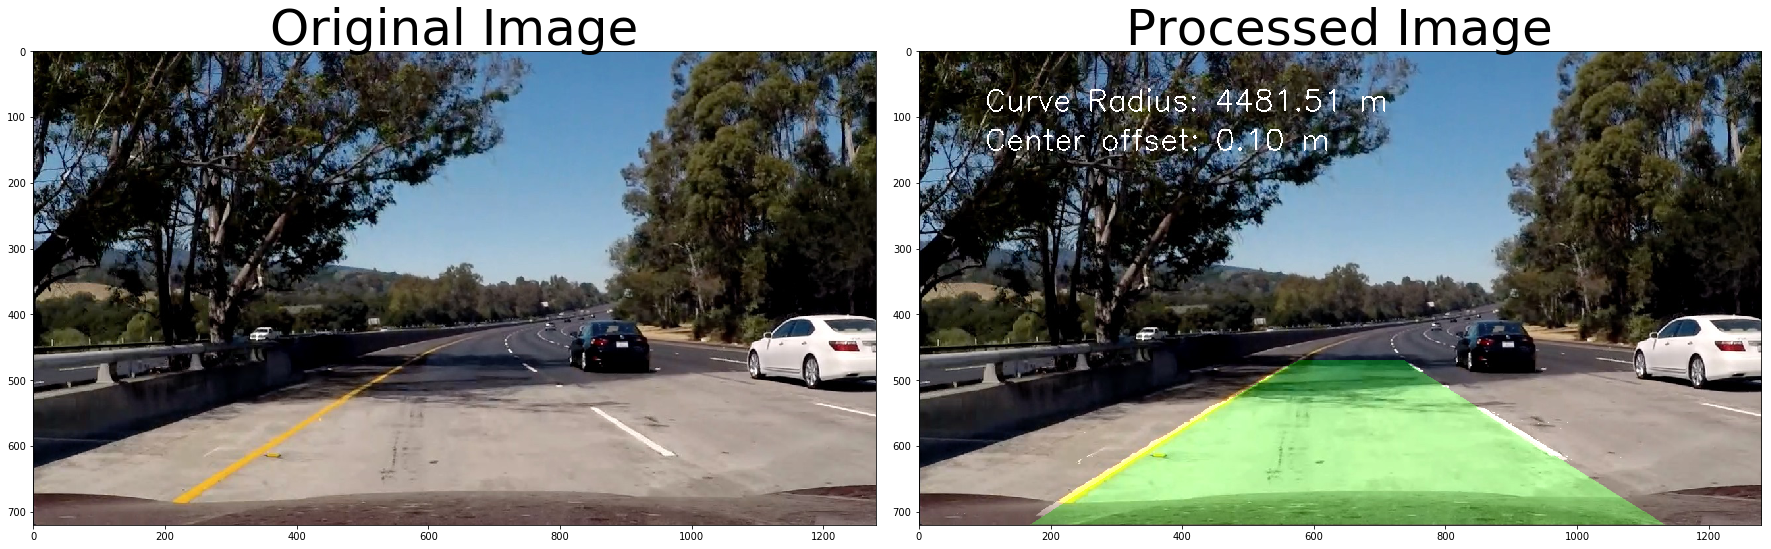

In [15]:
img = mpimage.imread('test_images/test5.jpg')

left_fit = None
right_fit = None

processed_img = pipeline(img)

# Plot the 2 images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(processed_img, cmap='gray')
ax2.set_title('Processed Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.savefig('write_up/test5_pipline.jpg')

# Pipeline Video

In [16]:
from moviepy.editor import VideoFileClip

In [17]:
left_fit = None
right_fit = None

input = VideoFileClip("project_video.mp4")
outputName = "write_up/project_video_output.mp4"

result = input.fl_image(pipeline)
%time result.write_videofile(outputName, audio = False)


[MoviePy] >>>> Building video write_up/project_video_output.mp4
[MoviePy] Writing video write_up/project_video_output.mp4


100%|█████████▉| 1260/1261 [03:48<00:00,  5.41it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: write_up/project_video_output.mp4 

CPU times: user 3min 55s, sys: 41.5 s, total: 4min 37s
Wall time: 3min 50s


In [ ]:
left_fit = None
right_fit = None

input = VideoFileClip("harder_challenge_video.mp4")
outputName = "output_video/hader_challnge_output.mp4"

result = input.fl_image(pipeline)
result.write_videofile(outputName, audio = False)